---

# Author: Arta Khosravi
## Last Update: Sept. 2024
### GitHub link: <a href="https://github.com/artakh10/Accretion-efficiency">Accretion disk efficiency</a>


---

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import sympy as sp
import seaborn as sns
import lmfit
import scipy as sy
from scipy.optimize import curve_fit, minimize_scalar
import scipy.signal as sig
from scipy.interpolate import UnivariateSpline
from pylab import *
import plotly.express as px
from constants_Acc import *
from function_Acc import *

## Volume and flux limit correction for data

In [3]:
pd.set_option('display.max_columns', None)
vol = pd.read_csv('flux_vol_eps_bins_2.5.csv')
vol_standard=vol[(10**vol['log_edd_ratio']<=1) | (1e-2<=10**vol['log_edd_ratio'])]
vol_standard['epsopt_3000']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_3000'])))
vol_standard['epsopt_1350']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_1350'])))
vol_standard['epsopt_1700']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_1700'])))
vol_standard['Object']=vol_standard['name']
vol_standard

,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,inf,inf,inf,inf,0.010598,inf,inf,0.640560,inf,0.010598,0.010598,0.000000,0.0
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,0.000000,0.0
2,2,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,0.000000,0.0
3,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,0.000000,0.0
4,4,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,inf,inf,inf,inf,0.140975,inf,inf,0.640888,inf,0.140975,0.140975,0.000000,0.0
89,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,inf,inf,inf,0.069832,0.040066,inf,0.640939,inf,0.040066,0.069832,0.040066,0.0
90,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,inf,inf,inf,inf,0.156498,inf,inf,0.640888,inf,0.156498,0.156498,0.000000,0.0
91,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,inf,inf,inf,0.080704,0.054506,inf,0.640833,inf,0.054506,0.080704,0.054506,0.0


In [5]:
vol_standard.fillna(np.inf, inplace=True)
#Finding max for L
df_L_min_vol = np.empty(len(vol_standard.index), dtype="O")
L_min_columns = vol_standard[['l_1700', 'l_3000','l_1350']].idxmin(axis=1)
for i, (r, c) in enumerate(zip(vol_standard.index, L_min_columns)):
    df_L_min_vol[i] = vol_standard._get_value(r, c)
vol_standard['L_min_col'] = df_L_min_vol
#Finding min for epsilon
vol_standard.fillna(np.inf, inplace=True)
vol_standard['epsopt_3000'] = vol_standard['epsopt_3000'].replace(0, np.nan)
vol_standard['epsopt_1700'] = vol_standard['epsopt_1700'].replace(0, np.nan)
vol_standard['epsopt_1350'] = vol_standard['epsopt_1350'].replace(0, np.nan)
eps_min_columns_vol = vol_standard[['epsopt_3000','epsopt_1700','epsopt_1350']].idxmin(axis=1)
eps_vol_min_list = np.empty(len(vol_standard.index),dtype="O")
for i, (r, c) in enumerate(zip(vol_standard.index, eps_min_columns_vol)):
    eps_vol_min_list[i] = vol_standard._get_value(r, c)
vol_standard['eps_min_total'] = eps_vol_min_list
vol_standard=vol_standard.drop_duplicates(subset='eps_min_col')
vol_standard.fillna(np.inf, inplace=True)
vol_standard['eps_min_col'] = vol_standard['eps_min_col'].replace(np.inf, np.nan)
vol_standard=vol_standard[(vol_standard['eps_min_col'].notna())].reset_index(drop=True)
vol_standard['log_edd_ratio'] = vol_standard['log_edd_ratio'].replace(np.inf, np.nan)
vol_standard=vol_standard[(vol_standard['log_edd_ratio'].notna())].reset_index(drop=True)
vol_standard

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-5-50b5357583b3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_standard['eps_min_col'] = vol_standard['eps_min_col'].replace(np.inf, np.nan)


,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700,L_min_col,eps_min_total
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,inf,inf,inf,inf,0.010598,inf,inf,0.640560,inf,0.010598,0.010598,inf,inf,45.958439,0.010598
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,inf,inf,46.470322,0.041062
2,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,inf,inf,46.560499,0.061637
3,5,SDSS J1306+0356,6.0170,9.230449,47.122544,-0.221849,19.736891,24.298100,-29.061209,-27.098350,57493.657912,46.410736,inf,inf,inf,inf,0.077563,inf,inf,0.640622,inf,0.077563,0.077563,inf,inf,46.410736,0.077563
4,7,SDSS J1306+0356,6.0180,9.462398,47.053463,-0.522879,19.910012,24.298519,-28.888507,-27.098769,57504.755357,46.341655,inf,inf,inf,inf,0.135307,inf,inf,0.640622,inf,0.135307,0.135307,inf,inf,46.341655,0.135307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,inf,inf,inf,inf,0.140975,inf,inf,0.640888,inf,0.140975,0.140975,inf,inf,45.954243,0.140975
71,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,inf,inf,inf,0.069832,0.040066,inf,0.640939,inf,0.040066,0.069832,0.040066,inf,46.462398,0.040066
72,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,inf,inf,inf,inf,0.156498,inf,inf,0.640888,inf,0.156498,0.156498,inf,inf,45.973128,0.156498
73,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,inf,inf,inf,0.080704,0.054506,inf,0.640833,inf,0.054506,0.080704,0.054506,inf,46.029384,0.054506


In [6]:
vol_standard = vol_standard.replace([np.inf], np.nan)
vol_standard_nonan=pd.DataFrame({'z':vol_standard['z'],'log_bh':vol_standard['log_bh'],'epsopt':vol_standard['eps_min_col']})
vol_standard_nonan=vol_standard_nonan[(vol_standard_nonan['epsopt'].notna())]
vol_standard_nonan.drop_duplicates()

,z,log_bh,epsopt
0,5.8440,8.000000,0.010598
1,5.8540,8.954243,0.041062
2,5.9030,9.204120,0.061637
3,6.0170,9.230449,0.077563
4,6.0180,9.462398,0.135307
...,...,...,...
70,6.9018,9.296665,0.140975
71,7.1000,9.208819,0.040066
72,6.9000,9.322219,0.156498
73,6.7000,9.031291,0.054506


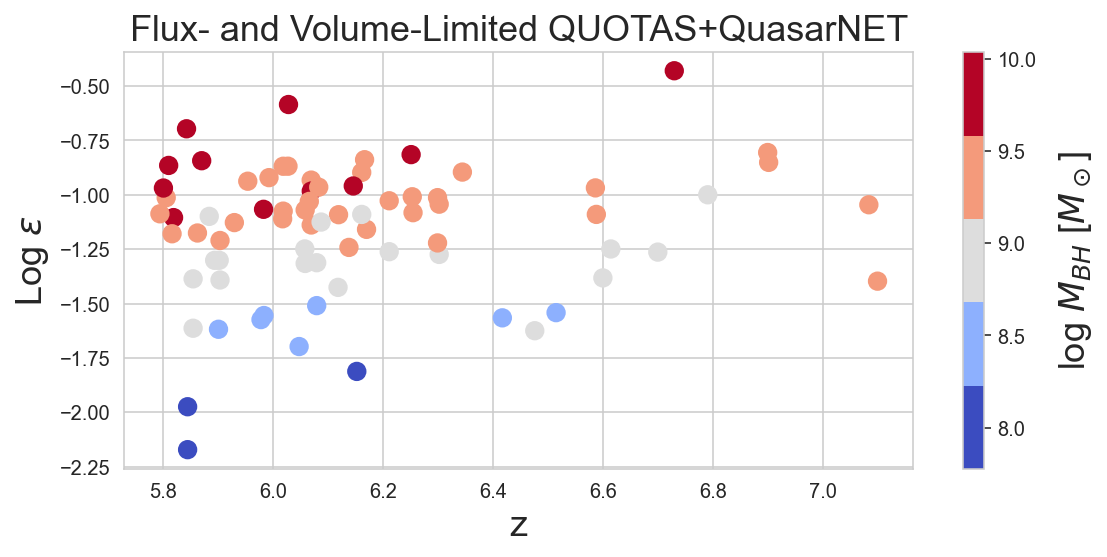

In [8]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=vol_standard_nonan.z, y=np.log10(vol_standard_nonan.epsopt), c=vol_standard_nonan.log_bh,s=75, 
                     cmap=cmap,label=' flux and volume limited QUOTAS + QuasarNET data points')
cbar=plt.colorbar(points)
cbar.set_label('$M_{BH}$', labelpad=10,size=13)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
plt.title('Flux- and Volume-Limited QUOTAS+QuasarNET',size=18)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
# plt.savefig('76_18_log_QN_vol_epsilon_vs_z_MBH_colored.pdf',dpi=600)
plt.show()

## DL11 data

In [10]:
D11=pd.read_csv('DR11.csv')
D11['epsilon_obsv']=10**(D11['logeps'])
D11['epsopt']=10**(D11['logeps'])
cols11=[4,6,8,11]
D11.drop(D11.columns[cols11],axis=1,inplace=True)
D11=D11.reset_index(drop=True)
Mbh_D11=[];eps_D11=[];Ledd_D11=[];edd_ratio_D11=[];
for i in range(len(D11)):
    Mbh_D11.append(MBHD11(D11['logLoptb'][i],D11['LogMdot'][i]))
for i in range(len(D11)):
    eps_D11.append(EpsilonKopt(10**D11['logLbolb'][i],10**D11['log_bh'][i],10**D11['logLoptb'][i]))
    Ledd_D11.append(Ledd(10**D11['log_bh'][i]))
    edd_ratio_D11.append(eddration(10**D11['log_bh'][i],10**D11['logLbolb'][i]))
D11['epsopt_lambda']=(Epsilonopt(10**(D11['logLbolb']),
                                       10**(D11['log_bh']),10**(D11['logLoptb'])))
for i in range(len(D11)):
    if D11['epsilon_obsv'][i]>10:
        D11=D11.drop([i])
D11=D11.drop_duplicates()
D11_standard=D11[(10**D11['log_edd_ratio']<=1) | (1e-2<=10**D11['log_edd_ratio'])].dropna().reset_index(drop=True)
D11_standard

,Object,z,log_bh,log_edd_ratio,logLoptb,LogMdot,logLbolb,logeps,epsilon_obsv,epsopt,epsopt_lambda
0,0003 + 158,0.4505,9.055,-0.358,45.87,0.79,46.92,-0.52,0.301995,0.301995,0.220847
1,0003 + 199,0.0260,7.220,-0.342,43.91,-0.06,45.13,-1.47,0.033884,0.033884,0.075656
2,0007 + 106,0.0893,8.561,-0.972,44.55,-0.42,45.52,-0.72,0.190546,0.190546,0.315087
3,0026 + 129,0.1452,7.833,0.053,44.99,0.80,46.15,-1.30,0.050119,0.050119,0.065194
4,0043 + 039,0.3859,8.952,-0.648,45.47,0.36,45.98,-1.04,0.091201,0.091201,0.083526
...,...,...,...,...,...,...,...,...,...,...,...
74,2209 + 184,0.0697,8.601,-1.353,44.11,-0.98,46.02,0.34,2.187762,2.187762,4.886867
75,2214 + 139,0.0657,8.308,-1.027,44.36,-0.50,45.15,-1.01,0.097724,0.097724,0.155582
76,2251 + 113,0.3255,8.816,-0.363,45.60,0.66,46.13,-1.18,0.066069,0.066069,0.056791
77,2304 + 042,0.0426,8.320,-1.633,43.67,-1.35,44.49,-0.81,0.154882,0.154882,0.383920


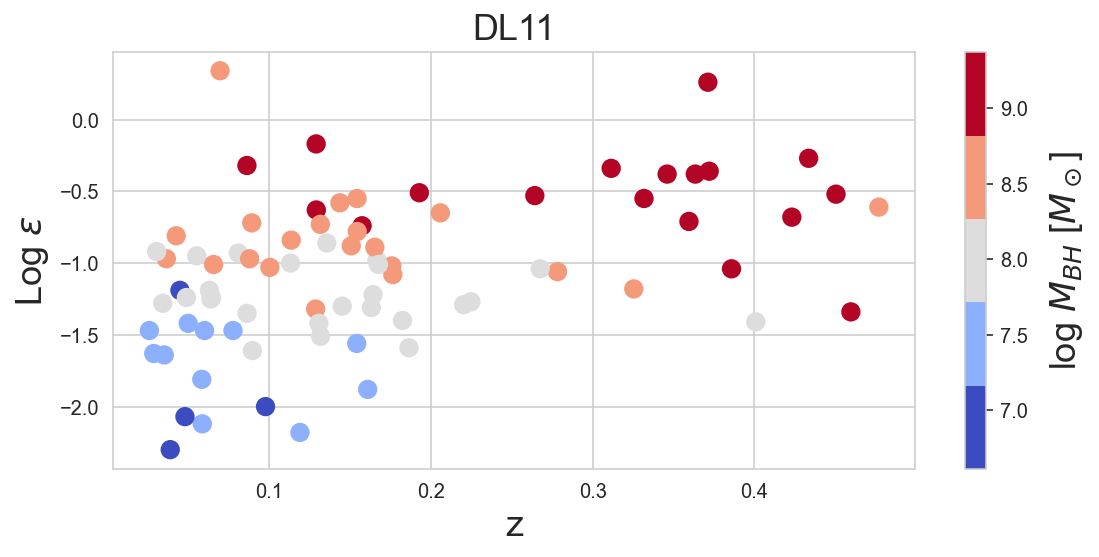

In [11]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=D11_standard.z, y=np.log10(D11_standard.epsilon_obsv), c=D11_standard.log_bh,s=75, 
                     cmap=cmap,label='$DL_{11}$')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
plt.xlabel('z',size=18)
plt.title('DL11',size=18)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
# plt.savefig('79_18_standard_log_D11_epsilon_vs_z_MBH_colored.pdf',dpi=600)
# plt.yscale('log')
plt.show()

## Combining DL11 and QUOTAS+QuasarNET

In [12]:
qn_dl11_vol=pd.concat([vol_standard_nonan,D11_standard],ignore_index=False)
qn_dl11_vol_cols=qn_dl11_vol.columns.tolist()
qn_dl11_vol_cols=['z','epsopt','log_bh']
qn_dl11_vol=qn_dl11_vol[qn_dl11_vol_cols]
qn_dl11_vol=qn_dl11_vol.dropna()
qn_dl11_vol=qn_dl11_vol.reset_index(drop=True).drop_duplicates()
qn_dl11_vol

,z,epsopt,log_bh
0,5.8440,0.010598,8.000000
1,5.8540,0.041062,8.954243
2,5.9030,0.061637,9.204120
3,6.0170,0.077563,9.230449
4,6.0180,0.135307,9.462398
...,...,...,...
149,0.0697,2.187762,8.601000
150,0.0657,0.097724,8.308000
151,0.3255,0.066069,8.816000
152,0.0426,0.154882,8.320000


The peaks of D11 + QN =[2.708]
y_cal = -0.01685 * x**2 + 0.09128 * x +  -1.07776 


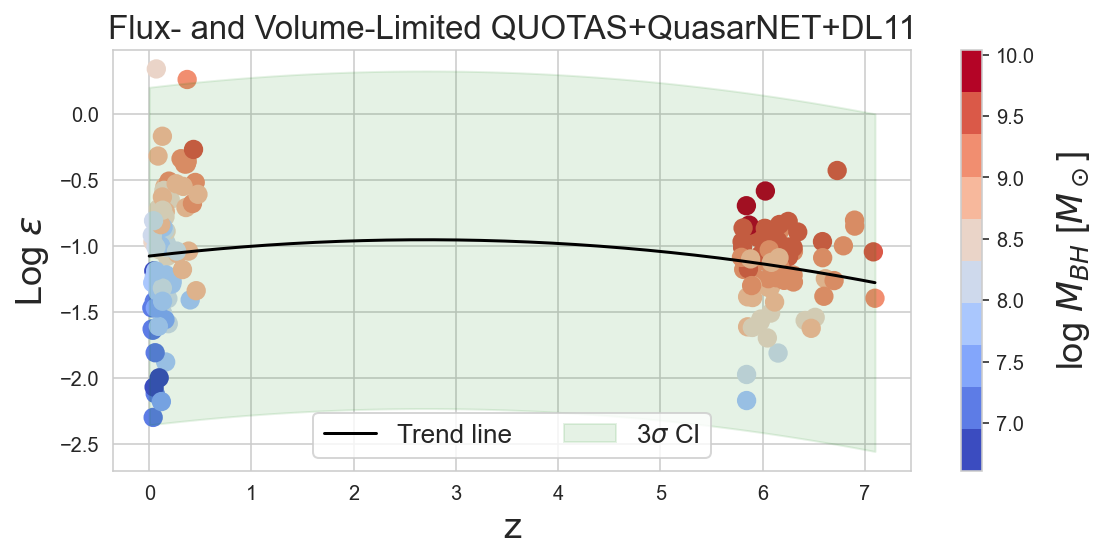

In [184]:
cmap = cm.get_cmap('coolwarm',10)
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
points = plt.scatter(x=qn_dl11_vol.z, y=np.log10(qn_dl11_vol.epsopt), c=qn_dl11_vol.log_bh,s=75, 
                     cmap=cmap)
qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]
x_hand = np.linspace(0,max(x_flvl),len(qn_dl11_vol_sort))
fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
fit_hand = obj(x_hand, fit_D_flvl, fit_E_flvl,fit_F_flvl)
def fit_Qnet(x):
    return fit_D_flvl * x**2 + fit_E_flvl * x +  fit_F_flvl
fit_Qnet_dict[0] = fit_Qnet
x_q=np.arange(0,max(x_flvl),0.001)
peaks, _ = sig.find_peaks(fit_Qnet_dict[0](x_q))
print("The peaks of D11 + QN ={}".format(x_q[peaks]))
print('y_cal = %.5f * x**2 + %.5f * x +  %.5f ' % (fit_D_flvl, fit_E_flvl,fit_F_flvl))
residuals_hand = y_flvl - fit_obj_flvl
sigma3_hand = 3 * np.std(residuals_hand)

plt.fill_between(x_hand, fit_Qnet(x_hand) - sigma3_hand, fit_Qnet(x_hand) + sigma3_hand, color='g', alpha=0.1, label='3$\sigma$ CI')
plt.plot(x_hand, fit_Qnet(x_hand), 'k', label='Trend line')

# plt.plot(x_flvl, fit_obj_flvl, 'black',label='Trend line')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
# plt.ylim(-0.5,1)
plt.title('Flux- and Volume-Limited QUOTAS+QuasarNET+DL11',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
plt.legend(ncol=3,loc='lower center',fontsize=13)
# plt.savefig('NEWFIT_3sigma_log_vol_epsilon_vs_z_11_qn_fit.pdf',dpi=600)
plt.show()

In [317]:
round(sigma3_hand,4)

1.2789

# Adding data from observatories for validation points

> ## $ \textbf{z} \sim \textbf{3.5} $ : DR7

In [13]:
df_3 = pd.read_csv('df_article.csv')
df_3['epsopt_5100']=(Epsilonopt(10**(df_3['log_lbol']),
                                       10**(df_3['log_bh']),10**(df_3['log_L5100'])))
df_3['epsopt_3000']=(Epsilonopt(10**(df_3['log_lbol']),
                                       10**(df_3['log_bh']),10**(df_3['log_L3000'])))
df_3['name']=df_3['Name (SDSS)']
df_3

,Name (SDSS),log_L3000,log_L5100,log_bh,log_lbol,z,epsopt_5100,epsopt_3000
0,J011521.20+152453.3g,46.70,46.61,9.43,47.57,3.443,0.162682,0.119218
1,J014214.75+002324.2g,46.86,46.61,9.80,47.58,3.379,0.355255,0.149810
2,J015741.57-010629.6g,46.91,46.72,9.99,47.68,3.572,0.450444,0.233690
3,J025021.76-075749.9g,46.85,46.63,9.49,47.60,3.337,0.183840,0.085989
4,J025905.63+001121.9g,47.10,47.01,9.50,47.97,3.373,0.117393,0.086028
5,J030341.04-002321.9g,47.00,46.82,9.47,47.79,3.233,0.141169,0.075812
6,J030449.85-000813.4g,47.03,46.82,9.12,47.79,3.287,0.068903,0.033361
7,J075303.34+423130.8g,46.84,46.74,10.09,47.71,3.590,0.552511,0.391147
8,J075819.70+202300.9m,46.83,46.67,9.74,47.64,3.761,0.292779,0.168477
9,J080430.56+542041.1g,47.08,46.91,10.13,47.87,3.759,0.480110,0.266895


In [229]:
df_3.fillna(np.inf, inplace=True)
#Finding max for L
df_3_L_min_vol = np.empty(len(df_3.index), dtype="O")
df_3_L_min_columns = df_3[['log_L5100', 'log_L3000']].idxmin(axis=1)
for i, (r, c) in enumerate(zip(df_3.index, df_3_L_min_columns)):
    df_3_L_min_vol[i] = df_3._get_value(r, c)
df_3['L_min_col'] = df_3_L_min_vol
#Finding min for epsilon
df_3.fillna(np.inf, inplace=True)
df_3['epsopt_3000'] = df_3['epsopt_3000'].replace(0, np.nan)
df_3['epsopt_5100'] = df_3['epsopt_5100'].replace(0, np.nan)
df_3_eps_min_columns_vol = df_3[['epsopt_3000','epsopt_5100']].idxmin(axis=1)
df_3_eps_vol_min_list = np.empty(len(df_3.index),dtype="O")
for i, (r, c) in enumerate(zip(df_3.index, df_3_eps_min_columns_vol)):
    df_3_eps_vol_min_list[i] = df_3._get_value(r, c)
df_3['eps_min_col'] = df_3_eps_vol_min_list
df_3=df_3.drop_duplicates(subset='eps_min_col')
df_3.fillna(np.inf, inplace=True)
df_3['epsopt'] = df_3['eps_min_col'].replace(np.inf, np.nan)
df_3=df_3[(df_3['eps_min_col'].notna())].reset_index(drop=True)
dr7_0_2 = df_3[(df_3['z'] <= 2) & (0 <= df_3['z'])].dropna().reset_index(drop=True)
dr7_2_4 = df_3[(df_3['z']<=4) & (2< df_3['z'])].dropna().reset_index(drop=True)
dr7_4 = df_3[(4<=df_3['z'])].dropna().reset_index(drop=True)
df_3

,Name (SDSS),log_L3000,log_L5100,log_bh,log_lbol,z,epsopt_5100,epsopt_3000,L_min_col,eps_min_col,epsopt
0,J011521.20+152453.3g,46.70,46.61,9.43,47.57,3.443,0.162682,0.119218,46.61,0.119218,0.119218
1,J014214.75+002324.2g,46.86,46.61,9.80,47.58,3.379,0.355255,0.149810,46.61,0.149810,0.149810
2,J015741.57-010629.6g,46.91,46.72,9.99,47.68,3.572,0.450444,0.233690,46.72,0.233690,0.233690
3,J025021.76-075749.9g,46.85,46.63,9.49,47.60,3.337,0.183840,0.085989,46.63,0.085989,0.085989
4,J025905.63+001121.9g,47.10,47.01,9.50,47.97,3.373,0.117393,0.086028,47.01,0.086028,0.086028
5,J030341.04-002321.9g,47.00,46.82,9.47,47.79,3.233,0.141169,0.075812,46.82,0.075812,0.075812
6,J030449.85-000813.4g,47.03,46.82,9.12,47.79,3.287,0.068903,0.033361,46.82,0.033361,0.033361
7,J075303.34+423130.8g,46.84,46.74,10.09,47.71,3.590,0.552511,0.391147,46.74,0.391147,0.391147
8,J075819.70+202300.9m,46.83,46.67,9.74,47.64,3.761,0.292779,0.168477,46.67,0.168477,0.168477
9,J080430.56+542041.1g,47.08,46.91,10.13,47.87,3.759,0.480110,0.266895,46.91,0.266895,0.266895


> ## $ \textbf{z} \sim \textbf{2} $ : Sofl (observed with SofI at the NTT of ESO/La Silla)

In [4]:
df_z_2 = pd.read_csv('newdata_test.csv').drop(columns=['Unnamed: 5'])
df_z_2['log_bh'] = np.log10(df_z_2['log_bh']*(1e+9))
df_z_2['epsopt']=(Epsilonopt((df_z_2['log_lbol'])*1e+46,
                                       10**(df_z_2['log_bh']),1e+46*(df_z_2['log_L5100'])))
df_z_2['name']=df_z_2['Object']
sofl_0_2 = df_z_2[(df_z_2['z'] < 2) & (0 < df_z_2['z'])].reset_index(drop=True)
sofl_2_4 = df_z_2[(df_z_2['z'] <= 4) & (2 < df_z_2['z'])].reset_index(drop=True)
sofl_4 = df_z_2[(4<=df_z_2['z'])].reset_index(drop=True)
df_z_2.log_L5100=np.log10(1e+46*(df_z_2.log_L5100))
df_z_2.log_lbol=np.log10(1e+46*(df_z_2.log_lbol))
df_z_2

,Object,z,log_lbol,log_L5100,log_bh,Unnamed: 5,epsopt,name
0,Q 0019+0107,2.131,46.421604,46.350248,9.977724,NaN,0.089440,Q 0019+0107
1,Q 0020-0154,1.465,46.429752,46.238046,9.255273,NaN,0.030543,Q 0020-0154
2,Q 0150-202,2.147,46.637490,46.640481,9.806180,NaN,0.037778,Q 0150-202
3,Q 0302-2223,1.406,46.436163,46.436163,9.959041,NaN,0.066137,Q 0302-2223
4,Q 2116-4439,1.504,46.264818,46.117271,9.301030,NaN,0.034956,Q 2116-4439
5,Q 2154-2005,2.042,46.301030,46.247973,9.643453,NaN,0.048761,Q 2154-2005
6,Q 2209-1842,2.098,46.431364,46.387390,9.505150,NaN,0.030541,Q 2209-1842
7,Q 2221-1759,2.230,46.394452,46.437751,9.716003,NaN,0.036347,Q 2221-1759
8,Q 2230+0232,2.215,46.303196,46.198657,9.531479,NaN,0.046189,Q 2230+0232
9,Q 2302+0255,1.062,46.511883,46.431364,9.505150,NaN,0.031524,Q 2302+0255


> ## $ z\sim 3-4 $ : Gemini/GNIRS near-infrared (NIR) spectroscopy

In [231]:
df_3_4=pd.read_csv('ds_z_3to4.csv').drop(columns=['ref'])
df_3_4['epsopt']=(Epsilonopt(10**(df_3_4['log_lbol']),
                                       10**(df_3_4['log_bh']),10**(df_3_4['log_L5100'])))
df_3_4['name']=df_3_4['Object']
gemini_0_2 = df_3_4[(df_3_4['z'] <= 2) & (0 <=df_3_4['z'])].dropna().reset_index(drop=True)
gemini_2_4 = df_3_4[(df_3_4['z']<=4) & (2< df_3_4['z'])].dropna().reset_index(drop=True)
gemini_4 = df_3_4[(4<=df_3_4['z'])].dropna().reset_index(drop=True)
df_3_4

,Object,z,log_bh,log_lbol,log_L5100,ref,epsopt,name
0,J0337?1204,3.44,9.0,46.36,46.055,https://academic.oup.com/mnras/article/527/3/5...,0.029056,J0337?1204
1,J0539?2839,3.14,9.3,46.70,46.843,NaN,0.007671,J0539?2839
2,J0733+0456,3.01,8.7,46.60,46.034,NaN,0.029197,J0733+0456
3,J0805+6144,3.03,9.0,46.34,46.193,NaN,0.017236,J0805+6144
4,J0833?0454,3.45,9.5,47.15,46.497,NaN,0.106498,J0833?0454
5,J1354?0206,3.72,9.0,46.78,46.151,NaN,0.054330,J1354?0206
6,J1429+5406,3.01,9.0,46.26,45.956,NaN,0.032564,J1429+5406
7,J1510+5702,4.31,9.6,46.63,46.615,NaN,0.026579,J1510+5702
8,J1635+3629,3.60,9.5,46.30,46.145,NaN,0.051742,J1635+3629


> ## $z \sim 4 $
> The spectra were obtained 
    using infrared and optical spectrographs of: 
    1) the Cerro Tololo Inter-American Observatory at Chile (OSIRIS, 4 m), (CTIO),
    2) the ESO observatories at La Silla (SofI, 3.5 m) (NTT) and Paranal( ISAAC, 8.2 m) at Chile (VLT),
    3) the Calar Alto Observatory (Twin, 3.5 m) at Spain, (CA) and
    4) and the W. M. Keck Observatory (NIRSPEC,10 m) at Hawaii (KECK).

In [332]:
df_z_4 = pd.read_csv('dataset_z4.csv')
df_z_4['log_bh'] = np.log10(df_z_4['log_bh']*(1e+9))
df_z_4['epsopt']=(Epsilonopt(10**(df_z_4['log_lbol']),
                                       10**(df_z_4['log_bh']),10**(df_z_4['log_L1450'])))
df_z_4['name']=df_z_4['Object']
keck_0_2 = df_z_4[(df_z_4['z'] <= 2) & (0 <=df_z_4['z'])].reset_index(drop=True)
keck_2_4 = df_z_4[(df_z_4['z']<=4) & (2< df_z_4['z'])].reset_index(drop=True)
keck_4 = df_z_4[(4<=df_z_4['z'])].reset_index(drop=True)
CTIO_z4 = df_z_4.loc[(df_z_4['Source'] == 'CTIO')]
VLT_z4 = df_z_4.loc[(df_z_4['Source'] == 'VLT')]
NTT_z4 = df_z_4.loc[(df_z_4['Source'] == 'NTT')]
KECK_z4 = df_z_4.loc[(df_z_4['Source'] == 'KECK')]
CA_z4 = df_z_4.loc[(df_z_4['Source'] == 'CA')]

,Object,z,log_lbol,log_bh,log_L1450,log_eddrat,Source,epsopt,name
8,PC 1158+4635...,4.73,48.03,9.799341,47.39,1.35,KECK,0.066904,PC 1158+4635...


> ## $0.9 \lesssim  z \lesssim  5$ : XXL-N survey (the largest XMM programme)

In [262]:
df_XXL = pd.read_csv('XXL_samp.csv')
df_XXL['epsopt']=(Epsilonopt(10**(df_XXL['log_lbol']),
                                       10**(df_XXL['log_bh']),10**(df_XXL['log_L4400'])))
df_XXL['name']=df_XXL['Name']
df_XXL=df_XXL.drop(columns=['ref']).dropna().reset_index(drop=True)
XXL_0_2 = df_XXL[(df_XXL['z'] <= 2) & (0 <=df_XXL['z'])].reset_index(drop=True)
XXL_2_4 = df_XXL[(df_XXL['z']<=4) & (2< df_XXL['z'])].reset_index(drop=True)
XXL_4 = df_XXL[(4<=df_XXL['z'])].reset_index(drop=True)
df_XXL

,Name,z,log_LX,log_lbol,log_L4400,log_bh,epsopt,name
0,1.237680e+18,5.0111,45.24,47.10,46.38,9.42,0.120820,1.237680e+18
1,1.237680e+18,3.1977,44.86,46.71,45.82,8.60,0.064009,1.237680e+18
2,1.237680e+18,3.1737,45.12,46.54,45.75,8.24,0.026457,1.237680e+18
3,1.237680e+18,3.0009,44.84,46.58,45.51,8.19,0.059929,1.237680e+18
4,1.237680e+18,2.7648,45.57,46.70,46.08,9.41,0.134042,1.237680e+18
5,1.237680e+18,2.7100,45.16,46.94,46.27,9.11,0.064989,1.237680e+18
6,1.237680e+18,2.7074,44.81,46.64,45.97,9.43,0.178090,1.237680e+18
7,1.237680e+18,2.6470,45.02,46.44,45.95,8.76,0.030644,1.237680e+18
8,1.237680e+18,2.6351,44.93,47.07,46.44,9.81,0.203958,1.237680e+18
9,1.237680e+18,2.6016,44.97,47.06,46.40,9.70,0.182701,1.237680e+18


> ## $4 \lesssim  z \lesssim  5.36$ : DR14

In [263]:
df_dr14 = pd.read_csv('SDSSDR14.csv').drop(columns=['ref'])
df_dr14['epsopt']=(Epsilonopt(10**(df_dr14['log_lbol']),
                                       10**(df_dr14['log_bh']),10**(df_dr14['log_L1350'])))
df_dr14['name']=df_dr14['Name']
dr14_0_2 = df_dr14[(df_dr14['z'] <= 2) & (0 <=df_dr14['z'])].reset_index(drop=True)
dr14_2_4 = df_dr14[(df_dr14['z']<=4) & (2< df_dr14['z'])].reset_index(drop=True)
dr14_4 = df_dr14[(4<=df_dr14['z'])].reset_index(drop=True)
df_dr14

,Name,z,log_L1350,log_lbol,log_bh,ref,epsopt,name
0,GB6J001115+144608,4.96,47.326,47.979,9.53,https://academic.oup.com/mnras/article/511/4/5...,0.042781,GB6J001115+144608
1,GB6J012202+030951,4.00,46.450,47.103,NaN,NaN,NaN,GB6J012202+030951
2,GB6J083548+182519,4.41,46.104,46.757,8.53,NaN,0.023146,GB6J083548+182519
3,GB6J083945+511206,4.40,46.795,47.448,9.69,NaN,0.110780,GB6J083945+511206
4,GB6J090631+693027,5.47,NaN,NaN,9.30,NaN,NaN,GB6J090631+693027
5,GB6J091825+063722,4.22,46.702,47.355,9.13,NaN,0.039218,GB6J091825+063722
6,GB6J102107+220904,4.26,46.007,46.660,8.94,NaN,0.060095,GB6J102107+220904
7,GB6J102623+254255,5.28,46.692,47.345,9.40,NaN,0.069007,GB6J102623+254255
8,GB6J132512+112338,4.42,46.568,47.221,9.17,NaN,0.049823,GB6J132512+112338
9,GB6J134811+193520,4.40,46.337,46.990,9.43,NaN,0.111337,GB6J134811+193520


-----

## New plots

The peaks of D11 + QN =[2.708]
y_cal = -0.01685 * x**2 + 0.09128 * x +  -1.07776 


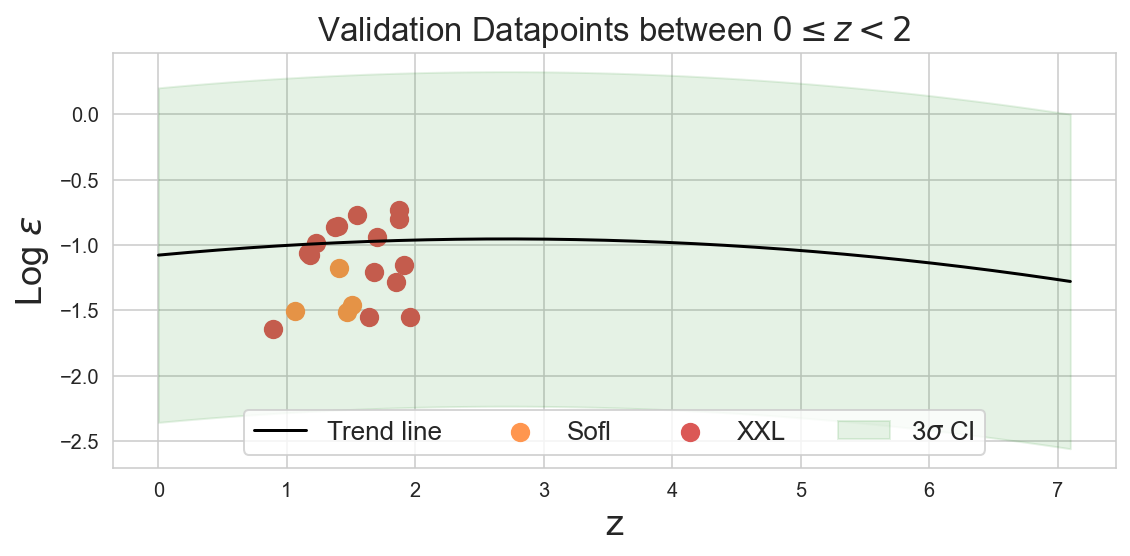

In [312]:
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
plt.scatter(x=sofl_0_2.z, y=np.log10(sofl_0_2.epsopt), s=75, c='xkcd:pastel orange',label = 'Sofl')
plt.scatter(x=XXL_0_2.z, y=np.log10(XXL_0_2.epsopt), s=75, c='xkcd:pastel red',label = 'XXL')

qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]
x_hand = np.linspace(0,max(x_flvl),len(qn_dl11_vol_sort))
fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
fit_hand = obj(x_hand, fit_D_flvl, fit_E_flvl,fit_F_flvl)

residuals_hand = y_flvl - fit_obj_flvl
sigma3_hand = 3 * np.std(residuals_hand)

plt.fill_between(x_hand, fit_Qnet(x_hand) - sigma3_hand, fit_Qnet(x_hand) + sigma3_hand, color='g', alpha=0.1, label='3$\sigma$ CI')
plt.plot(x_hand, fit_Qnet(x_hand), 'k', label='Trend line')


plt.xlabel('z',size=18)
# plt.ylim(-0.5,1)
plt.title('Validation Datapoints between $0 \leq z < 2$',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=4,loc='lower center',fontsize=13)
# plt.savefig('observatories_0_to_2_3sigma_log_vol_epsilon_vs_z_middata_fit.pdf',dpi=600)
plt.show()

The peaks of D11 + QN =[2.708]
y_cal = -0.01685 * x**2 + 0.09128 * x +  -1.07776 


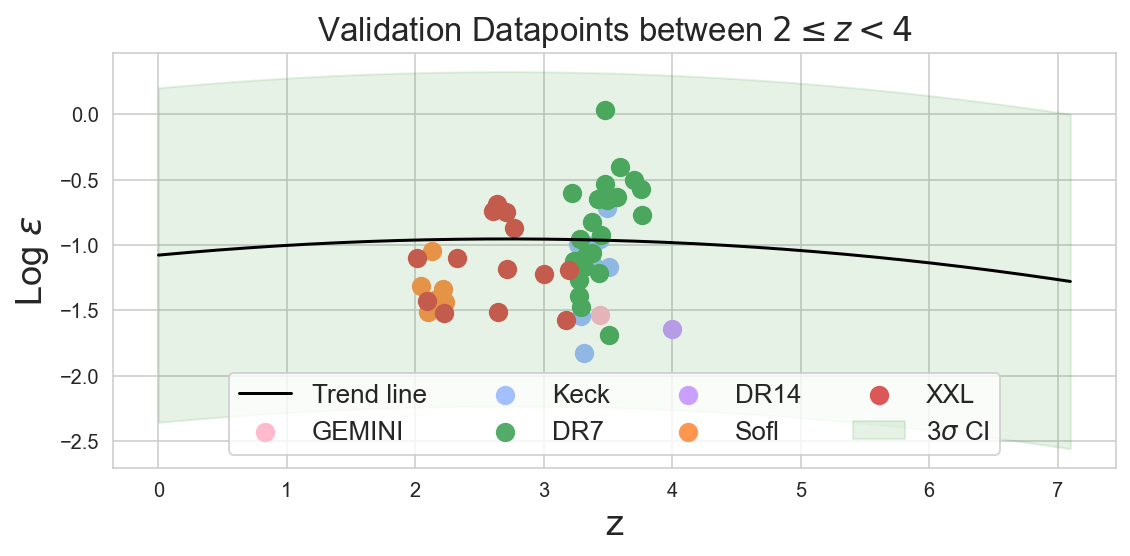

In [284]:
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
plt.scatter(x=gemini_2_4.z, y=np.log10(gemini_2_4.epsopt), s=75, c='xkcd:pastel pink',label = 'GEMINI')
plt.scatter(x=keck_2_4.z, y=np.log10(keck_2_4.epsopt), s=75, c='xkcd:pastel blue',label = 'Keck')
plt.scatter(x=dr7_2_4.z, y=np.log10(dr7_2_4.epsopt), s=75, c='xkcd:algae',label = 'DR7')
plt.scatter(x=dr14_2_4.z, y=np.log10(dr14_2_4.epsopt), s=75, c='xkcd:pastel purple',label = 'DR14')
plt.scatter(x=sofl_2_4.z, y=np.log10(sofl_2_4.epsopt), s=75, c='xkcd:pastel orange',label = 'Sofl')
plt.scatter(x=XXL_2_4.z, y=np.log10(XXL_2_4.epsopt), s=75, c='xkcd:pastel red',label = 'XXL')

qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]
x_hand = np.linspace(0,max(x_flvl),len(qn_dl11_vol_sort))
fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
fit_hand = obj(x_hand, fit_D_flvl, fit_E_flvl,fit_F_flvl)

residuals_hand = y_flvl - fit_obj_flvl
sigma3_hand = 3 * np.std(residuals_hand)

plt.fill_between(x_hand, fit_Qnet(x_hand) - sigma3_hand, fit_Qnet(x_hand) + sigma3_hand, color='g', alpha=0.1, label='3$\sigma$ CI')
plt.plot(x_hand, fit_Qnet(x_hand), 'k', label='Trend line')

plt.xlabel('z',size=18)
# plt.ylim(-0.5,1)
plt.title('Validation Datapoints between $2 \leq z < 4$',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=4,loc='lower center',fontsize=13)
plt.savefig('observatories_2_to_4_3sigma_log_vol_epsilon_vs_z_middata_fit.pdf',dpi=600)
plt.show()

The peaks of D11 + QN =[2.708]
y_cal = -0.01685 * x**2 + 0.09128 * x +  -1.07776 


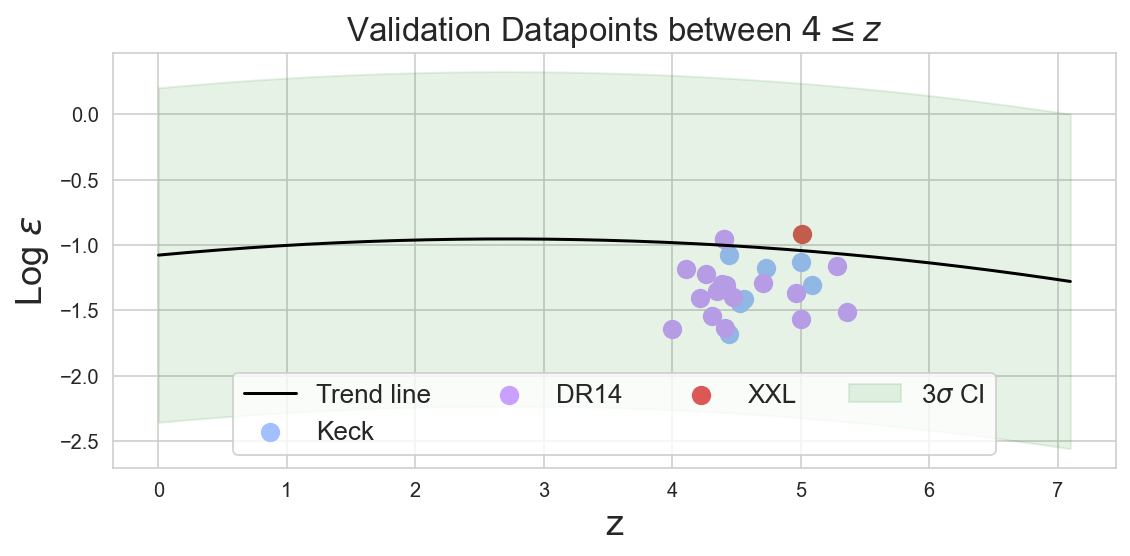

In [281]:
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
plt.scatter(x=keck_4.z, y=np.log10(keck_4.epsopt), s=75, c='xkcd:pastel blue',label = 'Keck')
plt.scatter(x=dr14_4.z, y=np.log10(dr14_4.epsopt), s=75, c='xkcd:pastel purple',label = 'DR14')
plt.scatter(x=XXL_4.z, y=np.log10(XXL_4.epsopt), s=75, c='xkcd:pastel red',label = 'XXL')

qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]
x_hand = np.linspace(0,max(x_flvl),len(qn_dl11_vol_sort))
fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
fit_hand = obj(x_hand, fit_D_flvl, fit_E_flvl,fit_F_flvl)

residuals_hand = y_flvl - fit_obj_flvl
sigma3_hand = 3 * np.std(residuals_hand)

plt.fill_between(x_hand, fit_Qnet(x_hand) - sigma3_hand, fit_Qnet(x_hand) + sigma3_hand, color='g', alpha=0.1, label='3$\sigma$ CI')
plt.plot(x_hand, fit_Qnet(x_hand), 'k', label='Trend line')

plt.xlabel('z',size=18)
# plt.ylim(-0.5,1)
plt.title('Validation Datapoints between $4 \leq z$',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=4,loc='lower center',fontsize=13)
plt.savefig('observatories_4_to_other_3sigma_log_vol_epsilon_vs_z_middata_fit.pdf',dpi=600)
plt.show()

The peaks of D11 + QN =[2.708]
y_cal = -0.01685 * x**2 + 0.09128 * x +  -1.07776 


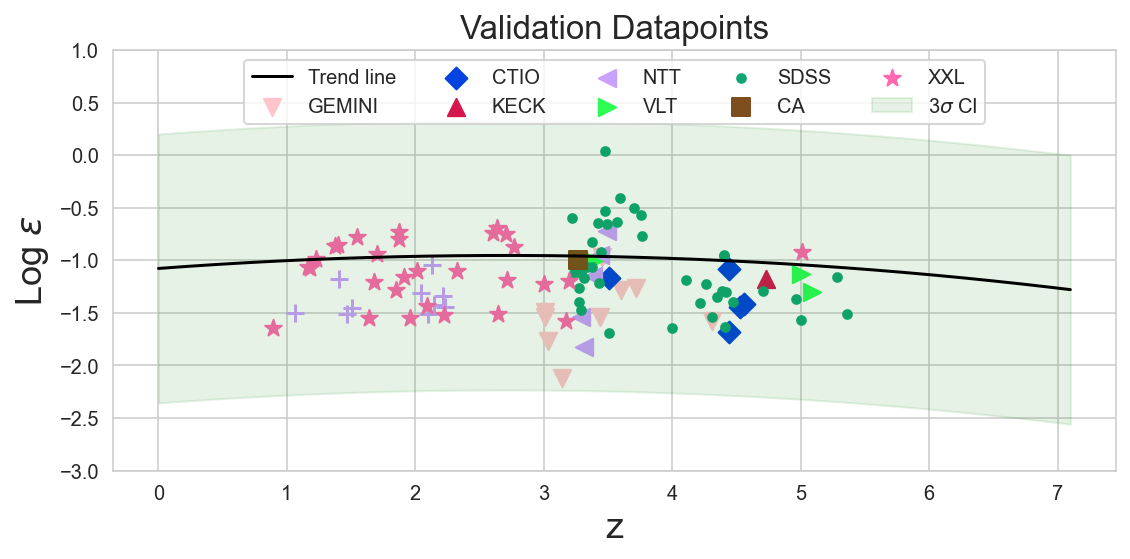

In [376]:
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
plt.scatter(x=df_3_4.z, y=np.log10(df_3_4.epsopt), s=75, c='xkcd:light rose',label = 'GEMINI',marker='v')
plt.scatter(x=CTIO_z4.z, y=np.log10(CTIO_z4.epsopt), s=60, c='xkcd:blue',label = 'CTIO',marker='D')
plt.scatter(x=KECK_z4.z, y=np.log10(KECK_z4.epsopt), s=75, c='xkcd:lipstick',label = 'KECK',marker='^')
plt.scatter(x=NTT_z4.z, y=np.log10(NTT_z4.epsopt), s=75, c='xkcd:pastel purple',label = 'NTT',marker='<')
plt.scatter(x=VLT_z4.z, y=np.log10(VLT_z4.epsopt), s=75, c='xkcd:bright light green',label = 'VLT',marker='>')
plt.scatter(x=df_3.z, y=np.log10(df_3.epsopt), s=75, c='xkcd:bluish green',label = 'SDSS',marker='.')
plt.scatter(x=CA_z4.z, y=np.log10(CA_z4.epsopt), s=75, c='xkcd:milk chocolate',label = 'CA',marker=',')
plt.scatter(x=df_dr14.z, y=np.log10(df_dr14.epsopt), s=75, c='xkcd:bluish green',marker='.')
plt.scatter(x=df_z_2.z, y=np.log10(df_z_2.epsopt), s=75, c='xkcd:pastel purple',marker='+') #NTT
plt.scatter(x=df_XXL.z, y=np.log10(df_XXL.epsopt), s=75, c='xkcd:bubble gum pink',label = 'XXL',marker='*')

qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]
x_hand = np.linspace(0,max(x_flvl),len(qn_dl11_vol_sort))
fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
fit_hand = obj(x_hand, fit_D_flvl, fit_E_flvl,fit_F_flvl)

residuals_hand = y_flvl - fit_obj_flvl
sigma3_hand = 3 * np.std(residuals_hand)

plt.fill_between(x_hand, fit_Qnet(x_hand) - sigma3_hand, fit_Qnet(x_hand) + sigma3_hand, color='g', alpha=0.1, label='3$\sigma$ CI')
plt.plot(x_hand, fit_Qnet(x_hand), 'k', label='Trend line')

plt.xlabel('z',size=18)
plt.ylim(-3,1)
plt.title('Validation Datapoints',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=5,loc='upper center',fontsize=10)
plt.savefig('observatories_ylim_fix_tot_3sigma_log_vol_epsilon_vs_z_middata_fit.pdf',dpi=600)
plt.show()

----